In [30]:
#import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# Multiple linear regression model and Data Loading functions

In [32]:
# Load and prepare the data
def load_data(file_path):
    data = pd.read_csv(file_path)
    data['Time'] = pd.to_datetime(data['Time'],format='%Y-%m-%d %H:%M:%S')

    # Data Processing: Add target variable: closing price at the next time step
    data['NextTimeStepClosing'] = data['Close'].shift(-1) #shift closing price to create target

    data = data.dropna() # drop last row

    #select subset of data
    data = data[-2000:]

    # Features: data of the current time step
    time = data['Time']
    X = data[['Open','High', 'Low', 'Close']]  #features

    
    Y = data['NextTimeStepClosing']                #target - closing price of next time

    return X, Y, time


# Define the Linear Regression model
class LinearRegression:
    def __init__(self, learning_rate=0.01, n_iterations=1000):
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.weights = None
        self.bias = None

    def fit(self, X, y):
        num_samples, num_features = X.shape
        self.weights = np.zeros(num_features)
        self.bias = 0

        for _ in range(self.n_iterations):
            # Calculate predictions
            y_pred = np.dot(X, self.weights) + self.bias

            # Compute gradients
            dw = (1 / num_samples) * np.dot(X.T, (y_pred - y))
            db = (1 / num_samples) * np.sum(y_pred - y)

            # Update weights and bias
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

    def predict(self, X):
        return np.dot(X, self.weights) + self.bias


# Data loading, Model Training and Performance Evaluation

In [38]:
# Load data
file_path = './Data/EURUSD_H4.csv'  # Replace with your CSV file path
X, y, time = load_data(file_path)

# Split data into training and test sets
X_train, X_test, y_train, y_test, time_train, time_test = train_test_split(X, y, time,  test_size=0.2, random_state=42, shuffle=False)

# Standardize features - unless volume added, not needed
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Initialize and train the model
model = LinearRegression(learning_rate=0.01, n_iterations=1000)
model.fit(X_train, y_train)

# Make Forecast
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Evaluate the model
train_mse = mean_squared_error(y_train, y_pred_train)
test_mse = mean_squared_error(y_test, y_pred_test)


print(f'Training MSE: {train_mse}')
print(f'Test MSE: {test_mse}')

'''
Data Processing: Re-Align test data and time and reset index
'''
y_test = y_test.reset_index(drop=True).iloc[1:] # exclude first row and reset index
time_test = time_test.reset_index(drop=True).iloc[1:]
y_pred_test = pd.Series(y_pred_test).shift(1) #convert prediction to a series
y_pred_test = y_pred_test.dropna()


#Construct dataframe for easy plotting 
resultsDataFrame= pd.DataFrame({
    'Date and Time': time_test,
    'Actual closing': y_test,
    'Fore. Closing': y_pred_test
})

print(resultsDataFrame.head())



Training MSE: 4.023771235478624e-06
Test MSE: 2.2903569143118253e-06
        Date and Time  Actual closing  Fore. Closing
1 2024-05-13 08:00:00         1.07953       1.077386
2 2024-05-13 12:00:00         1.07889       1.078338
3 2024-05-13 16:00:00         1.07920       1.079485
4 2024-05-13 20:00:00         1.07876       1.079183
5 2024-05-14 00:00:00         1.07871       1.078988


# Plot of Prediction and Forecasted Price

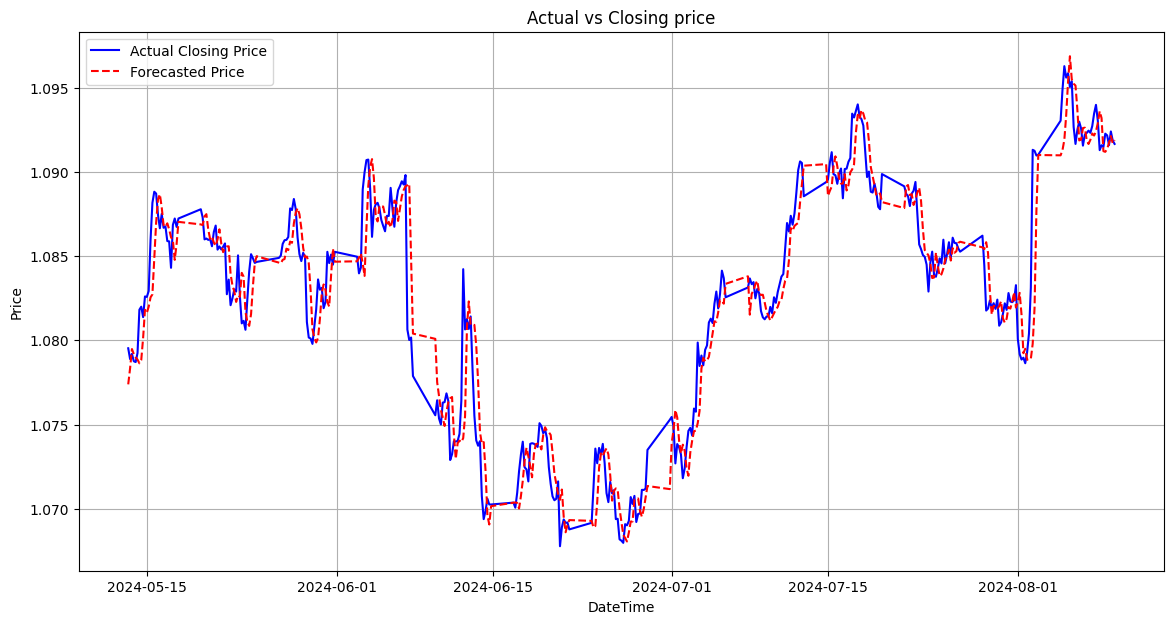

In [40]:
plt.figure(figsize=(14,7))
plt.plot(resultsDataFrame['Date and Time'], resultsDataFrame['Actual closing'], label='Actual Closing Price', color='blue')
plt.plot(resultsDataFrame['Date and Time'], resultsDataFrame['Fore. Closing'], label= 'Forecasted Price', color = 'red',linestyle='--')
plt.xlabel('DateTime')
plt.ylabel('Price')
plt.title('Actual vs Closing price')
plt.legend()
plt.grid(True)
plt.show()

# Trading strategy and Signal generation

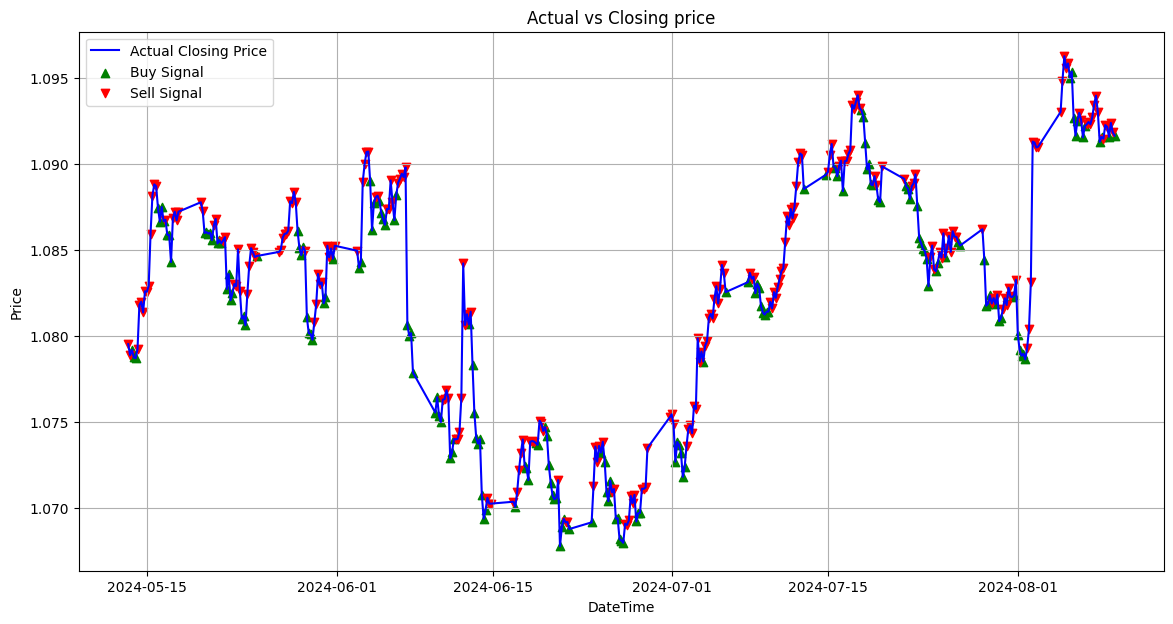

In [39]:
#generate trading signals -  store list of tuples
buy_signals =[]
sell_signals =[]


for i in range(len(y_test)):
    #enter long position
    if(y_pred_test.iloc[i] > y_test.iloc[i]):
        buy_signals.append((time_test.iloc[i], y_test.iloc[i]))
        sell_signals.append((None, None))
    #enter short position
    elif(y_pred_test.iloc[i] < y_test.iloc[i]):
        sell_signals.append((time_test.iloc[i], y_test.iloc[i]))
        buy_signals.append((None, None))
    #no trade opportunity
    else:
        sell_signals.append((None, None))
        buy_signals.append((None, None))

# Extract times and prices for plotting
buy_times = [signal[0] for signal in buy_signals if signal[0] is not None]
buy_prices = [signal[1] for signal in buy_signals if signal[1] is not None]
sell_times = [signal[0] for signal in sell_signals if signal[0] is not None]
sell_prices = [signal[1] for signal in sell_signals if signal[1] is not None]


# Plot buy and sell signals
plt.figure(figsize=(14,7))
plt.plot(resultsDataFrame['Date and Time'], resultsDataFrame['Actual closing'], label='Actual Closing Price', color='blue')
# plt.plot(resultsDataFrame['Date and Time'], resultsDataFrame['Fore. Closing'], label= 'Forecasted Price', color = 'red',linestyle='--')

plt.scatter(buy_times, buy_prices, marker='^', color='green', label='Buy Signal', alpha=1)
plt.scatter(sell_times, sell_prices, marker='v', color='red', label='Sell Signal', alpha=1)

plt.xlabel('DateTime')
plt.ylabel('Price')
plt.title('Actual vs Closing price')
plt.legend()
plt.grid(True)
plt.show()
